# Xopt Exaluator Basic Usage 

In [1]:
# needed for macos
import platform
if platform.system() == 'Darwin':
    import multiprocessing as mp                                                                                     
    mp.set_start_method("fork")    


In [2]:
from xopt import XoptBase, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.evaluator import DummyExecutor
import numpy as np
import pandas as pd
from time import sleep
from random import randint

In [3]:

vocs = VOCS(variables = {'x': [0,1], 'y': [0,1]}, objectives = {'f1':'MINIMIZE'})

def f(inputs):

    sleep(randint(1, 5)) # simulate computation time
    # Make some occasional errors
    if inputs['x'] > 0.8:
        raise ValueError('x > 0.8')

    return {'f1': inputs['x']**2 + inputs['y']**2}

in1 = vocs.random_inputs()
f(in1)

{'f1': 1.26315109341762}

In [4]:
X = XoptBase(RandomGenerator(vocs), Evaluator(f), vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
0,0.774621,0.605992
1,0.730791,0.908221
2,0.298219,0.621244
3,0.998891,0.227339


In [5]:
# Internal futures dictionary
X._futures

{0: <Future at 0x12a108ca0 state=finished returned dict>,
 1: <Future at 0x12a108a60 state=finished returned dict>,
 2: <Future at 0x105fdf910 state=finished returned dict>,
 3: <Future at 0x105c17fd0 state=finished raised ValueError>}

In [6]:
# Collect all finished futures and updata dataframe
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
0,0.774621,0.605992,0.967264,False,
1,0.730791,0.908221,1.358920,False,
2,0.298219,0.621244,0.474879,False,
3,0.998891,0.227339,NaN,True,"Traceback (most recent call last):\n File ""/U..."


In [7]:
# Futures are now cleared out
X._futures

{}

In [8]:
 # This is the internal counter
 X._ix_last

3

In [9]:
X.submit_data(vocs.random_inputs(4))
X._input_data 

,x,y
4,0.098137,0.503076
5,0.744581,0.243918
6,0.699955,0.321186
7,0.780077,0.963274


In [10]:
X._futures

{4: <Future at 0x149da0160 state=finished returned dict>,
 5: <Future at 0x106339be0 state=finished returned dict>,
 6: <Future at 0x105fdf850 state=finished returned dict>,
 7: <Future at 0x106308bb0 state=finished returned dict>}

In [11]:
# Singe generation step
X.step()
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
0,0.774621,0.605992,0.967264,False,
1,0.730791,0.908221,1.358920,False,
2,0.298219,0.621244,0.474879,False,
3,0.998891,0.227339,NaN,True,"Traceback (most recent call last):\n File ""/U..."
4,0.098137,0.503076,0.262717,False,
5,0.744581,0.243918,0.613897,False,
6,0.699955,0.321186,0.593098,False,
7,0.780077,0.963274,1.536418,False,
8,0.911417,0.913922,NaN,True,"Traceback (most recent call last):\n File ""/U..."


# Executors

In [12]:
from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import logging

In [13]:
MAX_WORKERS =10

In [ ]:
# Dask
client = Client( silence_logs=logging.ERROR)
executor = client.get_executor()
client

In [14]:
executor = ThreadPoolExecutor(max_workers=MAX_WORKERS)
#executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [15]:
X2 = XoptBase(RandomGenerator(vocs), Evaluator(f, executor=executor, max_workers=MAX_WORKERS), 
    vocs,
    asynch=True)

In [18]:
for _ in range(20):
    X2.step()
    X2.update_data()


<AxesSubplot:xlabel='x', ylabel='y'>

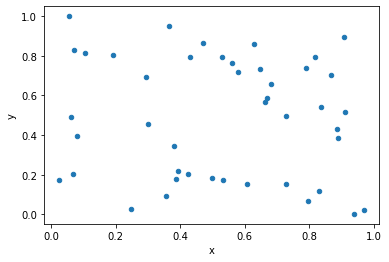

In [19]:
X2.data.plot.scatter('x', 'y')